# 第14章 断言和测试

[scalatest官网](https://www.scalatest.org)

断言和测试是我们用来检查软件行为符合预期的两种重要手段。本章将向你展示用Scala编写和运行断言和测试的若干选择。


In [1]:
//val path = System.getProperty("user.dir") + "/ref/load.sc"
//val module = ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path))
//interp.load.module(module)
import $ivy.`org.scalatest::scalatest:3.2.9`
import $ivy.`org.scalactic::scalactic:3.2.9`


Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest_2.12/3.2.9/scalatest_2.12-3.2.9.pom
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-wordspec_2.12/3.2.9/scalatest-wordspec_2.12-3.2.9.pom
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-matchers-core_2.12/3.2.9/scalatest-matchers-core_2.12-3.2.9.pom
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-flatspec_2.12/3.2.9/scalatest-flatspec_2.12-3.2.9.pom
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-shouldmatchers_2.12/3.2.9/scalatest-shouldmatchers_2.12-3.2.9.pom
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-diagrams_2.12/3.2.9/scalatest-diagrams_2.12-3.2.9.pom
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-mustmatchers_2.12/3.2.9/scalatest-mustmatchers_2.12-3.2.9.pom
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-funsuite_2.12/3.2.9/scalatest-funsuite_2.12-3.2.9.pom
Downloaded https://repo1.mav

Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-flatspec_2.12/3.2.9/scalatest-flatspec_2.12-3.2.9-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-wordspec_2.12/3.2.9/scalatest-wordspec_2.12-3.2.9-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-refspec_2.12/3.2.9/scalatest-refspec_2.12-3.2.9-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-matchers-core_2.12/3.2.9/scalatest-matchers-core_2.12-3.2.9.jar
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest_2.12/3.2.9/scalatest_2.12-3.2.9-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-mustmatchers_2.12/3.2.9/scalatest-mustmatchers_2.12-3.2.9-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-featurespec_2.12/3.2.9/scalatest-featurespec_2.12-3.2.9-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalatest/scalatest-funspec_2.12/3.2.9/scalatest-funspec_2.12-

import $ivy.$                               

import $ivy.$                               


In [2]:
import org.scalatest.funsuite.AnyFunSuite

import org.scalatest.funsuite.AnyFunSuite

## 14.1 断言

在Scala中，断言的写法是对预定义方法assert的调用。[1]如 果condition不满足，表达式assert（condition）将抛出AssertionError。assert还有另一个版本：assert（condition, explanation），首先检查condition是否满足，如果不满足，那么就抛出包含给定explanation的 AssertionError。explanation的类型为Any，因此可以传入任何对象。assert方法将调用explanation的 toString方法来获取一个字符串的解释放入AssertionError。例如，在示例10.13（205页）的Element类中名为 “above”的方法，可以在对widen的调用之后加入一行断言来确保被加宽的（两个）元素具有相同的宽度。参考示例14.1。

In [3]:
import Element.elem
  
abstract class Element {

    def contents: Array[String]

    def width: Int =
      if (height == 0) 0 else contents(0).length

    def height: Int = contents.length

    def above(that: Element): Element = {
      val this1 = this widen that.width
      val that1 = that widen this.width
      assert(this1.width == that1.width)
      elem(this.contents ++ that.contents)        
    }

  
    def beside(that: Element): Element =
      elem(
        for (
          (line1, line2) <- this.contents zip that.contents
        ) yield line1 + line2
      )
    
  private def widen(w: Int): Element =
    if (w <= width) 
      this 
    else { 
      val left = elem(' ', (w - width) / 2, height) 
      var right = elem(' ', w - width - left.width, height) 
      left beside this beside right 
    } ensuring (w <= _.width)

  
    override def toString = contents mkString "\n"
  }

  object Element {
  
    def elem(contents: Array[String]): Element = 
      new ArrayElement(contents)
  
    def elem(chr: Char, width: Int, height: Int): Element = 
      new UniformElement(chr, width, height)
  
    def elem(line: String): Element = 
      new LineElement(line)
  }

  class ArrayElement(conts: Array[String]) extends Element {
    def contents: Array[String] = conts
  }

  class LineElement(s: String) extends ArrayElement(Array(s)) {
    override def width = s.length
    override def height = 1
  }

  class UniformElement(
    ch: Char, 
    override val width: Int,
    override val height: Int 
  ) extends Element {
    private val line = ch.toString * width
    def contents = Array.fill(height)(line)
  }


import Element.elem
  

defined class Element
defined object Element
defined class ArrayElement
defined class LineElement
defined class UniformElement

ensuring 这个方法可以被用于任何结果类型，这得益于一个隐式转换。虽然这段代码看上去调用的是widen结果的ensuring方法，实际上调用的是某个可以从 Element隐式转换得到的类型的ensuring方法。该方法接收一个参数，这是一个接收结果类型参数并返回Boolean的前提条件函数。 ensuring所做的，就是把计算结果传递给这个前提条件函数。如果前提条件函数返回true，那么ensuring就正常返回结果；如果前提条件返回 false，那么ensuring将抛出AssertionError。

在本例中，前提条件函数是“w <= \_.width”。**这里的下画线是传入该函数的入参的占位符，即调用widen方法的结果**：一个Element。如果作为w传入widen方法的宽度小于 或等于结果Element的width，这个前提条件函数将得到true的结果，这样ensuring就会返回被调用的那个Element结果。由于这是 widen方法的最后一个表达式，widen本身的结果也就是这个Element了。

断言可以用JVM的命令行参数-e a和-d a来分别打开或关闭。打开时，断言就像是一个个小测试，用的是运行时得到的真实数据。在本章剩余的部分，我们将把精力集中在如何编写外部测试上，这些测试自己提供测试数据，并且独立于应用程序执行。

## 14.2 用Scala写测试

用Scala写测试，有很多选择，从已被广泛认可的Java工具，比如JUnit和TestNG，到用Scala编写的工具，比如ScalaTest、specs2和ScalaCheck。在本章剩余部分，我们将快速带你了解这些工具。我们从ScalaTest开始。

ScalaTest是最灵活的Scala测试框架：可以很容易地定制它来解决不同的问题。

ScalaTest的灵活性意味着团队可以使用任何最能满足他们需求的测试风格。例如，对于熟悉JUnit的团队，FunSuite风格是最舒适和熟悉的。参考示例14.3。

In [4]:
import org.scalatest.funsuite.AnyFunSuite
import Element.elem
class ElementSuite extends AnyFunSuite {
    test("elem result should have passed width"){
        val ele = elem('x',2,3)
        assert(ele.width == 2)
    }
}

import org.scalatest.funsuite.AnyFunSuite

import Element.elem

defined class ElementSuite

ScalaTest的核心概念是套件（suite），即测试的集合。所谓的测试（test）可以是任何带有名称，可以被启动，并且要么成功，要么失败，要么被暂停，要么被取消的代码。在ScalaTest中，Suite特质是核心组合单元。Suite声明了一组“生命周期”方法，定义了运行测试的默认方式，我们也可以重写这些方法来对测试的编写和运行进行定制。

ScalaTest提供了风格特质（style trait），这些特质扩展Suite并重写了生命周期方法来支持不同的测试风格。它还提供了混入特质（mixin trait），这些特质重写了生命周期方法来满足特定的测试需要。可以组合Suite的风格和混入特质来定义测试类，以及通过编写Suite实例来定义测试套件。

示例14.3中的测试类扩展自FunSuite，这就是风格特质的一个例子。FunSuite中的“Fun”指的是函数；而“test”是定义在FunSuite中的一个方法，该方法被ElementSuite的主构造方法调用。可以在圆括号中用字符串给出测试的名称，并在花括号中给出具体的测试代码。测试代码是一个以传名参数传入test的函数，test将这个函数登记下来，稍后执行。

ScalaTest已经被集成进常见的构建工具（比如sbt和Maven）和IDE（比如IntelliJ IDEA和Eclipse）。也可以通过ScalaTest的Runner应用程序直接运行Suite，或者在Scala解释器中简单地调用它的execute方法。比如：


In [5]:
(new ElementSuite).execute()

cmd3$Helper$ElementSuite:
- elem result should have passed width


ScalaTest的所有风格，包括FunSuite在内，都被设计为鼓励编写专注的、带有描述性名称的测试。不仅如此，所有的风格都会生成规格说明书般的输出，方便在干系人之间交流。你所选择的风格只规定了你的测试代码长成什么样，不论你选择什么样的风格，ScalaTest的运行机制都始终保持一致。[2]

## 14.3 翔实的失败报告
示例14.3中的测试尝试去创建一个宽度为2的元素，并断言产出的元素的宽度的确为2。如果这个断言失败了，失败报告就会包括文件名和该断言所在的行号，以及一条翔实的错误消息：


In [6]:
val width = 3

width: Int = 3

In [12]:
import org.scalatest.Assertions._
assert(width == 2)//这里显示的和书上的不同，可能是scalatest包没有引入

: 

In [ ]:
import org.scalatest.Assertions._

为了在断言失败时提供描述性的错误消息，ScalaTest会在编译时分析传入每次assert调用的表达式。如果你想要看到更详细的关于断言失败的信息，可以使用ScalaTest的DiagrammedAssertions，其错误消息会显示传入assert的表达式的一张示意图：
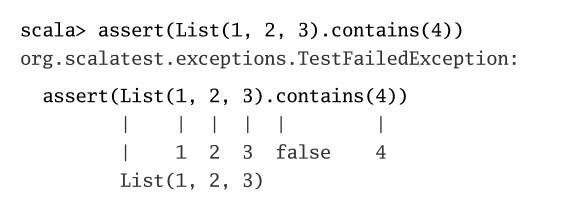

ScalaTest 的a s s e r t方法并不在错误消息中区分实际和预期的结果，它们仅仅是提示我们左侧的操作元跟右侧的操作元不相等，或者在示意图中显示出表达式的值。如果你想要强调实 际和预期的差别，可以换用ScalaTest的assertResult方法，就像这样：
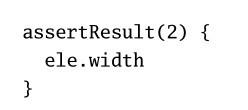
通过这个表达式，你表明了你预期花括号中的代码的执行结果是2。如果花括号中的代码执行结果是3，你将会在失败报告中看到“Expected 2, but got 3”这样的消息。

如果你想要检查某个方法抛出某个预期的异常，可以用ScalaTest的assertThrows方法，就像这样：
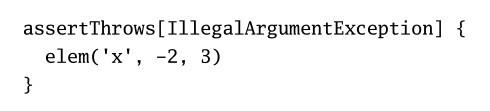
如果花括号中的代码抛出了不同于预期的异常，或者并没有抛出异常， assertThrows将以TestFailedException异常终止。你将在失败报告中得到一个对排查问题有帮助的错误消息，比如：
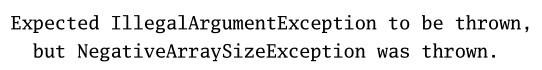
而如果代码以传入的异常类的实例异常终止（即代码抛出了预期的异常）, assertThrows将正常返回。如果你想要进一步检视预期的异常，可以使用intercept而不是assertThrows。intercept 方法跟assertThrows的运行机制相同，不过当异常被抛出时，intercept将返回这个异常：
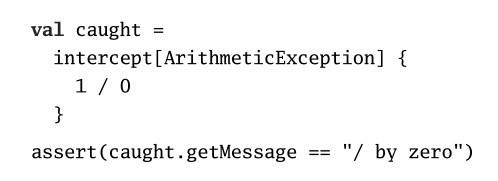

简而言之，ScalaTest的断言会尽其所能提供有助于我们诊断和修复代码问题的失败消息。
## 14.4 作为规格说明的测试

行为驱动开发（BDD）测试风格的重点是编写人类可读的关于代码预期行为的规格说明，同时给出验证代码具备指定行为的测试。ScalaTest包含了若干特质来支持这种风格的测试。示例14.4给出了这样的一个特质FlatSpec的例子。

In [19]:
import org.scalatest.flatspec.AnyFlatSpec
import org.scalatest._
import matchers.should._
import Element.elem

class ElementSpec extends AnyFlatSpec with Matchers {
    "A UniformElement" should
        "have a width equal to the passed value" in {
            val ele = elem('x', 2, 3)
            ele.width should be (2)
        }
    it should "have a height equal to the passed value" in {
        val ele = elem('x', 2, 3)
        ele.height should be (3)
    }
    it should "throw an IAE if passed a negative width" in {
        an [IllegalArgumentException] should be thrownBy {
            elem('x', -2, 3)
        }
    }
}


import org.scalatest.flatspec.AnyFlatSpec

import org.scalatest._

import matchers.should._

import Element.elem


defined class ElementSpec

在FlatSpec中，我们以规格子句（specifier clause）的形式编写测试。我们先写下以字符串表示的要测试的主体（subject） （即示例14.4中的＂A UniformElement＂），然后是should（must或can），再然后是一个描述该主体需要具备的某种行为的字符串，再接下来是in。在in后面的花括号中，我们编写用于测试指定行为的代码。在后续的子句中，可以用it来指代最近给出的主体。当一个FlatSpec被执行时，它将每个规格 子句作为ScalaTest测试运行。FlatSpec（以及ScalaTest的其他规格说明特质）在运行后将生成读起来像规格说明书的输出。例如，以 下就是当你在解释器中运行示例14.4中的ElementSpec时输出的样子：

In [21]:
(new ElementSpec).execute()

cmd18$Helper$ElementSpec:
A UniformElement
- should have a width equal to the passed value
- should have a height equal to the passed value
- should throw an IAE if passed a negative width *** FAILED ***
  Expected exception java.lang.IllegalArgumentException to be thrown, but no exception was thrown (cmd18.sc:17)


示例14.4还展示了ScalaTest的匹配器（matcher） 领域特定语言（DSL）。通过混入Matchers特质，可以编写读上去更像自然语言的断言。ScalaTest在其DSL中提供了许多匹配器，并允许你 用定制的失败消息定义新的matcher。示例14.4中的匹配器包括“should be”和“an [...] should be thrownBy {...}”这样的语法。如果相比should你更喜欢must，也可以选择混入MustMatchers。例如，混入MustMatchers将允许你编写这样的表达式：
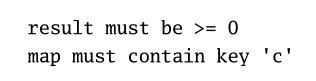
如果最后的断言失败了，你将看到类似于下面这样的错误消息：
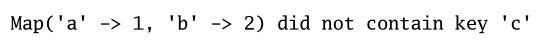
specs2测试框架是Eric Torreborre用Scala编写的开源工具，也支持BDD风格的测试，不过语法不太一样。可以用specs2来编写同样的测试，如示例14.5所示。

跟ScalaTest一样，specs2也提供了匹配器DSL。在示例14.5中，你能看到一些specs2匹配器的实际用例，即那些包含了“must be_==”和“must throwA”的行。[3]可以单独使用specs2，不过它也被集成在ScalaTest和JUnit中，因此也可以用这些工具来运行specs2测试。

BDD 的一个重要思想是测试可以在那些决定软件系统应该做什么的人、那些实现软件的人和那些判定软件是否完成并正常工作的人之间架起一道沟通的桥梁。虽然 ScalaTest和specs2的任何一种风格都可以这样来用，但是ScalaTest的FeatureSpec是专门为此设计的。参考示例14.6。
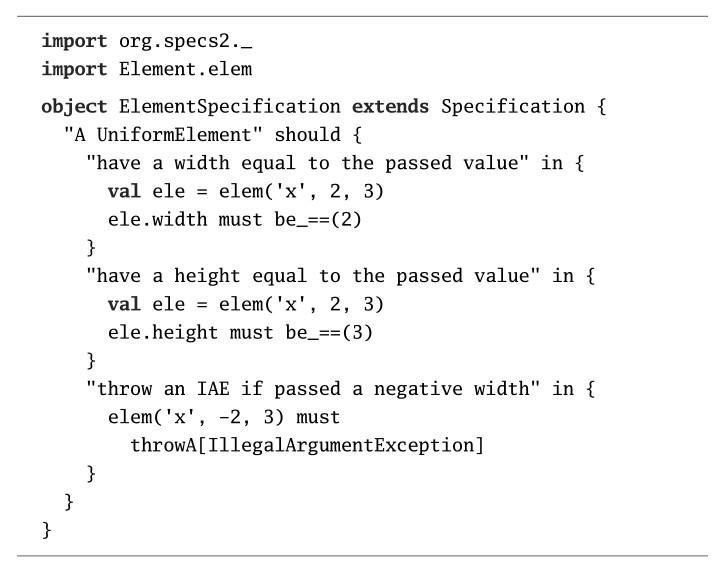
<center>示例14.5 用specs2框架描述并测试代码行为</center>

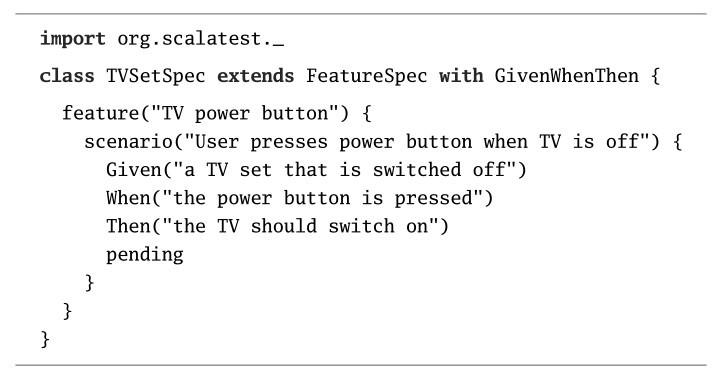
<center>示例14.6 用测试在干系人之间进行沟通</center>


FeatureSpec的设计目的是引导关于软件需求的对话：必须指明具体的功能（feature），然后用场景（scenario） 来描述这些功能。Given、When、Then方法（由GivenWhenThen特质提供）能帮助我们将对话聚焦在每个独立场景的具体细节上。最后的 pending调用表明测试和实际的行为都还没有实现——这里只是规格说明。一旦所有的测试和给定的行为都实现了，这些测试就会通过，我们就可以说需求已经满足。

## 14.5 基于性质的测试

Scala 的另一个有用的测试工具是ScalaCheck，这是由Rickard Nilsson编写的开源框架。ScalaCheck让你能够指定被测试的代码必须满足的性质。对每个性质，ScalaCheck都会生成数据并执行断言，检查代码是否满足该性质。示例14.7给出了一个混入了PropertyChecks特质的WordSpec的ScalaTest中使用 ScalaCheck的例子。
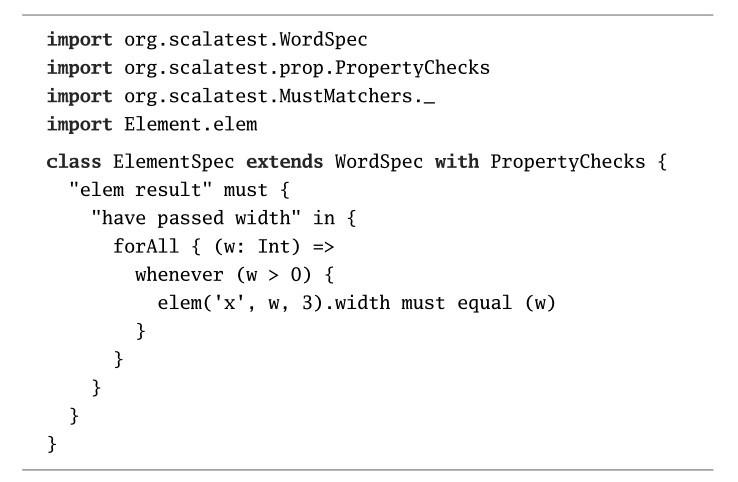
<center>示例14.7 用ScalaCheck编写基于性质的测试</center>

WordSpec是一个ScalaTest的风格类。PropertyChecks特质提供了若干forAll方法，让你可以将基于性质的测试跟传统的基于断言或基于匹配器的测试混合在一起。在本例中，我们检查了一个elem工厂必须满足的性质。ScalaCheck的性质在代码中表现为以参数形式接收性质断言所需的数据的函数值。这些数据将由ScalaCheck代我们生成。对于示例14.7中的性质，数据是名为w的整数，代表宽度。在这个函数的函数体中，你看到这段代码：
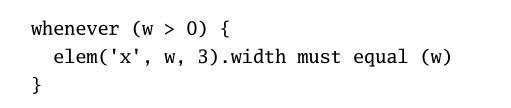

whatever子句表达的意思是，只要左边的表达式为true，那么右边的表达式也必须为true。因此在本例中，只要w大于0，代码块中的表达式就必须为true。当传给elem工厂的宽度跟工厂返回Element的宽度一致时，本例的右侧表达式就会交出true。

只需要这样一小段代码，ScalaCheck就会帮助我们生成数百条w可能的取值并对每一个执行测试，尝试找出不满足该性质的值。如果对于ScalaCheck尝试的每个值，该性质都满足，测试就通过了。否则，测试就将以TestFailedException终止，这个异常会包含关于造成该测试失败的值的信息。

## 14.6 组织和运行测试

本章提到的每一个测试框架都提供了某种组织和运行测试的机制。本节将快速地介绍ScalaTest采用的方式。当然，如果想全面了解这些测试框架，你需要查看它们的文档。

在ScalaTest中，我们通过将Suite嵌套在别的Suite当中来组织大型的测试套件。当Suite被执行时，它将执行嵌套的Suite以及其他测试。而这些被嵌套的Suite也会相应地执行它们内部嵌套的Suite，如此往复。因此，我们可以把一个大型的测试套件看作是Suite对象组成的树形结构。当你执行这棵树的根节点时，树中所有Suite都会被执行。

可以手动或自动嵌套测试套件。手动的方式是在你的Suite中重写nestedSuite方法，或将你想要嵌套的Suite作为参数传给Suites类的构造方法，这个构造方法是ScalaTest专门为此提供的。自动的方式是将包名提供给ScalaTest的Runner，它会自动发现Suite套件，并 将它们嵌套在一个根Suite里，并执行这个根Suite。

可以从命令行调用ScalaTest的Runner应用程序，也可以通过构建工具，比如sbt、maven或ant来调用。通过命令行调用Runner最简单的方式是通过org.scalatest.run。这个应用程序预期一个完整的测试类名。例如，要执行示例14.6中的测试类，必须用下面的命令来执行编译：
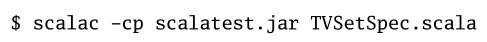


然后用下面的命令来运行：
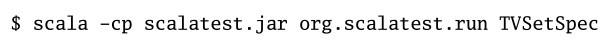
需要通过-cp参数将ScalaTest的JAR文件包含在类路径中（下载的JAR文件名会包含Scala和ScalaTest的版本号）。接下来的命令行参数，org.scalatest.run，是完整的应用程序类名。Scala将会运行这个应用程序并传入剩余的命令行参数。TVSetSpec这个参数指定了要执行的套件。执行结果如图14.1所示。
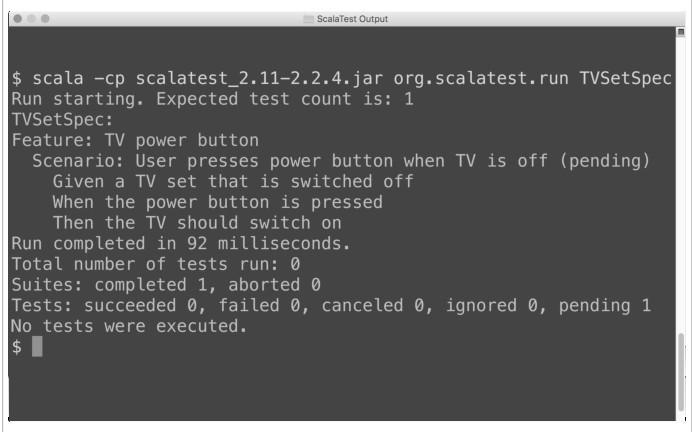
<center>图14.1 org.scalatest.run的输出</center>

## 14.7 结语

在本章你看到了将断言直接混在生产代码内的例子，以及以外部测试的形式编写的例子。作为Scala程序员，可以利用Java社区倍受欢迎的测试工具，比如 JUnit和TestNG，以及更新的、专门为Scala设计的工具，比如ScalaTest、ScalaCheck和specs2。不论是代码中的断言 还是外部测试都能够帮助你达到软件质量的目标。我们认为这些技巧非常重要，值得在这本Scala教程中单独开辟一章来简短地做一下介绍。在下一章，我们将 回到语言本身，介绍Scala的一个非常实用的特性：模式匹配。

[1].assert方法定义在Predef单例对象中，每个Scala源文件都会自动引入该单例对象的成员。

[2].关于ScalaTest的更多内容请查阅 http://www.scalatest.org/。

[3].可以从 http://specs2.org/ 下载specs2。